In [3]:
# %% [markdown]
# Implant scheme summary and visualization helpers

# %%
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('./..')
sys.path.append('./../..')

import pickle
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from dynaphos import utils
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulator

In [4]:
# ---------------------------
# Config: schemes and view angles
# ---------------------------
SCHEMES = [
    ("defaultcoordinatemap_1024", "../electrode_schemes/defaultcoordinatemap_1024.pickle", 16.0),
    ("4utaharrays",               "../electrode_schemes/4utaharrays.pickle",               16.0),
    ("1utaharray",                "../electrode_schemes/1utaharray.pickle",                0.4),
    ("neuralink",                 "../electrode_schemes/neuralink.pickle",                 25.0),
    ("utahRFs",                   "../electrode_schemes/utahRFs.pickle",                   6.0),
]

# Base params
params = utils.load_params('../config/params.yaml')

# ---------------------------
# Utilities
# ---------------------------
def load_map(path):
    with open(path, 'rb') as f:
        coords = pickle.load(f)
    return coords

def in_view_mask(x, y, view_angle, origin=(0.0, 0.0)):
    half = view_angle / 2.0
    x0, y0 = origin
    return (
        (x >= x0 - half) & (x <= x0 + half) &
        (y >= y0 - half) & (y <= y0 + half)
    )

def nearest_neighbor_distances(x, y, sample_if_large=True, max_n=3000, rng=None):
    """
    Compute nearest neighbor distances in degrees.
    When there are many points, optionally subsample for speed.
    """
    rng = np.random.default_rng() if rng is None else rng
    pts = np.column_stack([x, y])

    if sample_if_large and len(pts) > max_n:
        idx = rng.choice(len(pts), size=max_n, replace=False)
        pts = pts[idx]

    # Pairwise distances
    # For numerical stability, set diagonal to large value and take the min
    diffs_x = pts[:, None, 0] - pts[None, :, 0]
    diffs_y = pts[:, None, 1] - pts[None, :, 1]
    D = np.sqrt(diffs_x**2 + diffs_y**2)
    np.fill_diagonal(D, np.inf)
    nn = D.min(axis=1)
    return nn

def summarize_scheme(name, path, view_angle, base_params):
    """
    Return a dict with summary stats for one scheme.
    """
    coords = load_map(path)
    x, y = coords.cartesian
    r, phi = coords.polar

    x = np.asarray(x)
    y = np.asarray(y)
    r = np.asarray(r)
    phi = np.asarray(phi)

    # In view
    origin = tuple(base_params['run']['origin'])
    m = in_view_mask(x, y, view_angle, origin=origin)

    n_total = len(x)
    n_in = int(m.sum())
    coverage = 100.0 * n_in / max(1, n_total)

    # Eccentricity stats (in degrees)
    r_in = r[m]
    ecc_min = float(np.min(r_in)) if n_in > 0 else np.nan
    ecc_med = float(np.median(r_in)) if n_in > 0 else np.nan
    ecc_max = float(np.max(r_in)) if n_in > 0 else np.nan

    # Nearest neighbor distances in degrees (in view only)
    nn = nearest_neighbor_distances(x[m], y[m]) if n_in > 1 else np.array([np.nan])
    nn_mean = float(np.mean(nn))
    nn_std = float(np.std(nn))

    # Build a simulator once to ensure consistency with your pipeline
    # and to record the final number of valid phosphenes after removal
    params_local = utils.load_params('../config/params.yaml')
    params_local['run']['view_angle'] = float(view_angle)
    simulator = PhospheneSimulator(params_local, coords)
    n_after = simulator.num_phosphenes  # after removal of any out of view points

    return {
        "scheme": name,
        "view_angle_deg": float(view_angle),
        "n_in_pickle": int(n_total),
        "n_in_view_box": int(n_in),
        "n_after_simulator": int(n_after),
        "coverage_in_view_percent": coverage,
        "ecc_min_deg": ecc_min,
        "ecc_median_deg": ecc_med,
        "ecc_max_deg": ecc_max,
        "nn_mean_deg": nn_mean,
        "nn_std_deg": nn_std,
    }

def summarize_all_schemes(schemes, base_params):
    rows = []
    for name, path, v in schemes:
        if not os.path.exists(path):
            print(f"[skip] {name}: file not found at {path}")
            continue
        try:
            rows.append(summarize_scheme(name, path, v, base_params))
        except Exception as e:
            print(f"[error] {name}: {e}")
    df = pd.DataFrame(rows)
    # Sort by view angle then scheme name
    if not df.empty:
        df = df.sort_values(["view_angle_deg", "scheme"]).reset_index(drop=True)
    return df

In [5]:
df_props = summarize_all_schemes(SCHEMES, params)
display(df_props.style.format({
    "view_angle_deg": "{:.2f}",
    "coverage_in_view_percent": "{:.1f}",
    "ecc_min_deg": "{:.2f}",
    "ecc_median_deg": "{:.2f}",
    "ecc_max_deg": "{:.2f}",
    "nn_mean_deg": "{:.3f}",
    "nn_std_deg": "{:.3f}",
}))

,scheme,view_angle_deg,n_in_pickle,n_in_view_box,n_after_simulator,coverage_in_view_percent,ecc_min_deg,ecc_median_deg,ecc_max_deg,nn_mean_deg,nn_std_deg
0,1utaharray,0.40,94,94,94,100.0,0.01,0.11,0.20,0.011,0.005
1,utahRFs,6.00,256,256,256,100.0,0.00,0.94,2.12,0.004,0.028
2,4utaharrays,16.00,320,320,320,100.0,1.63,2.52,7.93,0.078,0.066
3,defaultcoordinatemap_1024,16.00,1024,1024,1024,100.0,0.00,1.73,7.98,0.174,0.191
4,neuralink,25.00,4224,4224,4224,100.0,0.00,0.00,12.09,0.040,0.127


In [8]:
df_props.to_csv("implant_schemes_summary.csv", index=False)
print(df_props.to_csv(index=False))

scheme,view_angle_deg,n_in_pickle,n_in_view_box,n_after_simulator,coverage_in_view_percent,ecc_min_deg,ecc_median_deg,ecc_max_deg,nn_mean_deg,nn_std_deg
1utaharray,0.4,94,94,94,100.0,0.008889858185605743,0.10561197336482411,0.2029032147568772,0.011313576719363044,0.005416184704879444
utahRFs,6.0,256,256,256,100.0,0.0,0.9413289978360132,2.1203773249117717,0.0038959771040999783,0.028491656452448128
4utaharrays,16.0,320,320,320,100.0,1.6324857717113936,2.5169008678695683,7.9314556882447125,0.07811154855401656,0.06578262062932647
defaultcoordinatemap_1024,16.0,1024,1024,1024,100.0,0.001,1.7345170170170168,7.983985985985986,0.17389110483549353,0.19102866426817397
neuralink,25.0,4224,4224,4224,100.0,0.0,0.0,12.094800535767424,0.040387541706403476,0.12695411168967125



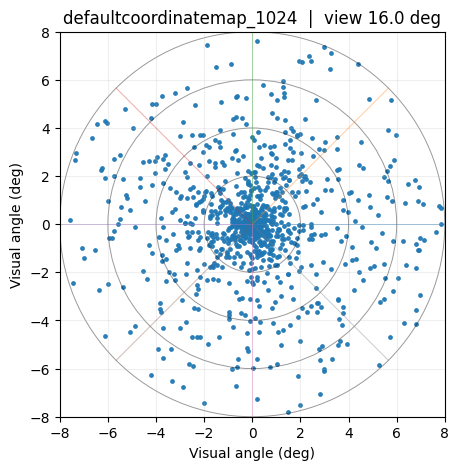

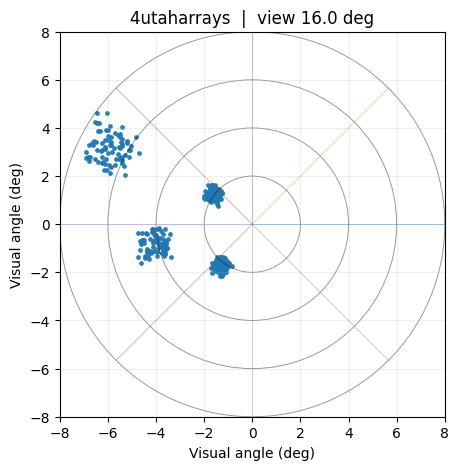

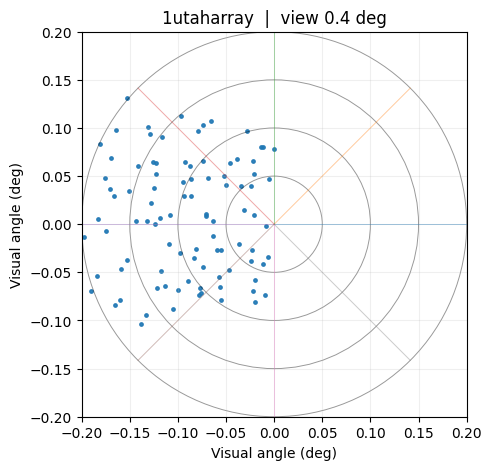

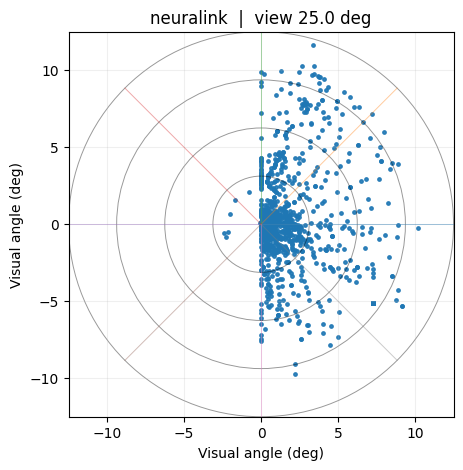

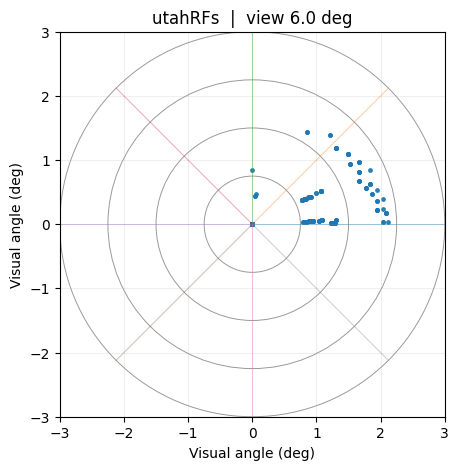

In [6]:
def plot_phosphene_locations(coords, view_angle, title="Phosphene locations with visual field axis"):
    x, y = coords.cartesian
    x = np.asarray(x)
    y = np.asarray(y)

    half = view_angle / 2.0
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(x, y, s=6, alpha=0.9)

    # Concentric circles and radial lines
    radii = np.linspace(half / 4.0, half, 4)
    phis = np.linspace(0, 2 * np.pi, 8, endpoint=False)
    for R in radii:
        c = plt.Circle((0, 0), R, fill=False, lw=0.7, alpha=0.4)
        ax.add_artist(c)
    for phi in phis:
        ax.plot([0, half * np.cos(phi)], [0, half * np.sin(phi)], lw=0.7, alpha=0.4)

    ax.set_xlim(-half, half)
    ax.set_ylim(-half, half)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel("Visual angle (deg)")
    ax.set_ylabel("Visual angle (deg)")
    ax.set_title(title)
    ax.grid(True, alpha=0.2)
    plt.show()

# Example: plot each available scheme
for name, path, v in SCHEMES:
    if not os.path.exists(path):
        continue
    coords = load_map(path)
    plot_phosphene_locations(coords, v, title=f"{name}  |  view {v} deg")
